In [29]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import datasets, layers, models,regularizers
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import matplotlib.pyplot as plt
import random

In [4]:
mobile=tf.keras.applications.MobileNetV2()

14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [5]:
def prepare_image(file):
  #img_path="/content/sample_data/"
  img=image.load_img( file ,target_size=(224,224))
  img_array=image.img_to_array(img)
  img_array_expanded_dims=np.expand_dims(img_array,axis=0)
  return tf.keras.applications.mobilenet_v2.preprocess_input(img_array_expanded_dims)

In [ ]:
from IPython.display import Image
Image(filename='t.png',width=300,height=300)

FileNotFoundError: [Errno 2] No such file or directory: 't.png'

In [ ]:
from google.colab import files
files.upload()

In [ ]:
preprocessed_image = prepare_image('OIP.jfif')
prediction=mobile.predict(preprocessed_image)
results=imagenet_utils.decode_predictions(prediction)
results

In [ ]:
os.chdir("/content/drive/MyDrive/GoogleColab-MobileNet-FineTuning/HandSignDataset")
if os.path.isdir("train/0/") is False:
  os.mkdir('train')
  os.mkdir('valid')
  os.mkdir('test')

  for i in range(0,10):
    shutil.move(f'{i}','train')
    os.mkdir(f'valid/{i}')
    os.mkdir(f'test/{i}')

    valid_samples=random.sample(os.listdir(f'train/{i}'),30)
    for j in valid_samples:
      shutil.move(f'train/{i}/{j}',f'valid/{i}')

    test_samples=random.sample(os.listdir(f'train/{i}'),5)
    for k in test_samples:
      shutil.move(f'train/{i}/{k}',f'test/{i}')
#os.chdir('../..')


In [6]:
train_path='/content/drive/MyDrive/GoogleColab-MobileNet-FineTuning/HandSignDataset/train'
valid_path='/content/drive/MyDrive/GoogleColab-MobileNet-FineTuning/HandSignDataset/valid'
test_path='/content/drive/MyDrive/GoogleColab-MobileNet-FineTuning/HandSignDataset/test'

In [7]:
train_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input).flow_from_directory(
    directory=train_path,target_size=(224,224),batch_size=10)
valid_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input).flow_from_directory(
    directory=valid_path,target_size=(224,224),batch_size=10)
test_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input).flow_from_directory(
    directory=test_path,target_size=(224,224),batch_size=10,shuffle=False)

Found 1732 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [ ]:
mobile.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [71]:
x=mobile.layers[-2].output
y = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
z = layers.Dropout(0.5)(y)
output=Dense(units=10,activation='softmax')(z)

In [72]:
model=Model(inputs=mobile.input,outputs=output)

In [73]:
for layer in model.layers[9:34]:
  layer.trainable=False

In [70]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 7,173,568 (27.36 MB)

 Trainable params: 2,375,162 (9.06 MB)

 Non-trainable params: 48,080 (187.81 KB)

 Optimizer params: 4,750,326 (18.12 MB)

In [74]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])


In [12]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [75]:
with tf.device('/device:GPU:0'):
  model.fit(x=train_batches,validation_data=valid_batches,epochs=20,verbose=2)
from tensorflow.keras.models import load_model
model.save('/content/drive/MyDrive/GoogleColab-MobileNet-FineTuning/handsignmodel3.keras')

Epoch 1/20
174/174 - 66s - 379ms/step - accuracy: 0.9457 - loss: 0.5021 - val_accuracy: 0.9933 - val_loss: 0.2387
Epoch 2/20
174/174 - 48s - 276ms/step - accuracy: 0.9977 - loss: 0.2467 - val_accuracy: 0.9967 - val_loss: 0.2445
Epoch 3/20
174/174 - 19s - 112ms/step - accuracy: 0.9988 - loss: 0.2302 - val_accuracy: 0.9967 - val_loss: 0.2370
Epoch 4/20
174/174 - 10s - 56ms/step - accuracy: 0.9983 - loss: 0.2278 - val_accuracy: 0.9967 - val_loss: 0.2267
Epoch 5/20
174/174 - 9s - 52ms/step - accuracy: 0.9983 - loss: 0.2192 - val_accuracy: 0.9967 - val_loss: 0.2306
Epoch 6/20
174/174 - 9s - 54ms/step - accuracy: 1.0000 - loss: 0.2038 - val_accuracy: 0.9967 - val_loss: 0.2266
Epoch 7/20
174/174 - 11s - 62ms/step - accuracy: 0.9994 - loss: 0.1969 - val_accuracy: 0.9967 - val_loss: 0.2213
Epoch 8/20
174/174 - 9s - 51ms/step - accuracy: 0.9971 - loss: 0.1965 - val_accuracy: 0.9933 - val_loss: 0.1973
Epoch 9/20
174/174 - 9s - 53ms/step - accuracy: 0.9988 - loss: 0.1840 - val_accuracy: 0.9967 - v

In [41]:
model.save('/content/drive/MyDrive/GoogleColab-MobileNet-FineTuning/handsignmodel2.keras')

In [76]:
test_labels=test_batches.classes

In [77]:
from keras.models import load_model
#model = load_model('/content/drive/MyDrive/GoogleColab-MobileNet-FineTuning/handsignmodel2.keras')
predictions=model.predict(x=test_batches,verbose=0)

In [78]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [43]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]


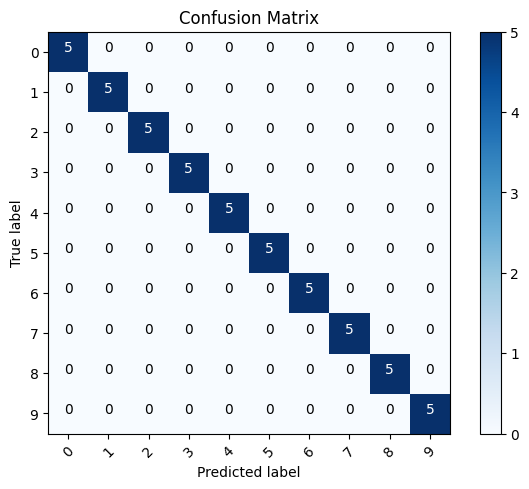

In [79]:
#from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_true=test_labels,y_pred=predictions.argmax(axis=1))
#import seaborn as sns
#sns.heatmap(cm,annot=True)
#plt.title('Confusion Matrix', fontsize = 20)
#plt.xlabel('Actual', fontsize = 15)
#plt.ylabel('Prediccted', fontsize = 15)
cm_plot_labels=['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title='Confusion Matrix')

In [ ]:
from tensorflow.keras.models import load_model
model.save('/content/drive/MyDrive/GoogleColab-MobileNet-FineTuning/handsignmodel.keras')

In [104]:
from keras.models import load_model
#model = load_model('/content/drive/MyDrive/GoogleColab-MobileNet-FineTuning/handsignmodel.keras')
x=prepare_image("/content/drive/MyDrive/GoogleColab-MobileNet-FineTuning/p.jpg")
predictions=model.predict(x=x,verbose=0)
predictions.argmax(axis=1)

array([9])

In [ ]:
np.testing.assert_allclose(
    model.predict("/content/drive/MyDrive/GoogleColab-MobileNet-FineTuning/t.jpg"), model.predict("/content/drive/MyDrive/GoogleColab-MobileNet-FineTuning/t.jpg")
)